# Load libraries 

In [2]:
#load libraries 
import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines , numpy as np, math, pylab
#import ROOT
#from ROOT import TFile

import root_pandas
%matplotlib inline

#presets for plot style
from scipy.constants import golden
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 7/golden),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

from scipy.optimize import curve_fit


Welcome to JupyROOT 6.23/01


# Load tuple files
The following will automatically download the files from https://userweb.jlab.org/~spaul/sidis_tuple_examples, if they are not already downloaded.  

In [3]:
import urllib.request, os

for filename in "example_mc_large.root",:
    if not (filename in os.listdir(".")):
        url = 'https://userweb.jlab.org/~spaul/sidis_tuples_examples/' +filename
        urllib.request.urlretrieve(url, filename)
        print("downloaded file from " + url)
    else:
        print("found file: " + filename + ",\t no need to re-download")
print("done downloading files")

found file: example_mc_large.root,	 no need to re-download
done downloading files


Now load the tuples from the files.

In [4]:
#electrons: events with at least one electron which passes DIS event selection cuts
#hadrons: events with at least one electron (passing cuts above) and at least one charged hadron
#dihadrons: events with at least one electron and two charged hadrons, one of which is a "leading" pion, (ie, z>0.5)


#same for Monte-Carlo simulations
mc_electrons = root_pandas.read_root("example_mc_large.root", "electrons")
mc_hadrons = root_pandas.read_root("example_mc_large.root", "hadrons")
mc_dihadrons = root_pandas.read_root("example_mc_large.root", "dihadrons")

In [5]:
#apply cuts in order to match the event selection used by Orlando
mc_hadrons = mc_hadrons.query("h_p>1.25 and h_p<5 and h_th>3.14159/180*5 and h_th<3.14159/180*35 and y<0.8")
mc_electrons = mc_electrons.query("y<0.8")

In [6]:
#print the number of entries in each tuple
print("mc electrons\tlength =", len(mc_electrons))
print("mc hadrons\tlength =", len(mc_hadrons))
print("mc dihadrons\tlength =", len(mc_dihadrons))

mc electrons	length = 2138909
mc hadrons	length = 213511
mc dihadrons	length = 10132


In [8]:
def binspace(df, query, min, max, nbins):
    ls = np.linspace(min,max,nbins)
    return [df.query("%s> %s and %s < %s" %(query, mn, query, mx)) for mn,mx in zip(ls[:-1],ls[1:])]

def binomialError(num,denom):
    #return num/denom*np.sqrt(1/min(1,num)+1/min(1,denom))
    if denom == 0:
        return 1
    return 1/denom**(3/2)*np.sqrt(num*(denom-num))
    
def getmeanstd(df, query):
    a = df.eval(query)
    x0, sigma = np.mean(a), np.std(a)
    nbins = 50
    bins = binspace(df,query, x0-5*sigma, x0+5*sigma, nbins)
    x = np.linspace(x0-5*sigma, x0+5*sigma, nbins-1)
    x += (x[1]-x[0])/2
    y = [len(bin) for bin in bins]
    del bins
    def gaus(x,a,x0,sigma):
        return a*np.exp(-(x-x0)**2/(2*sigma**2))
    
    popt,pcov = curve_fit(gaus,x,y,p0=[1,x0,sigma])

    return popt[1],abs(popt[2])

# Plots

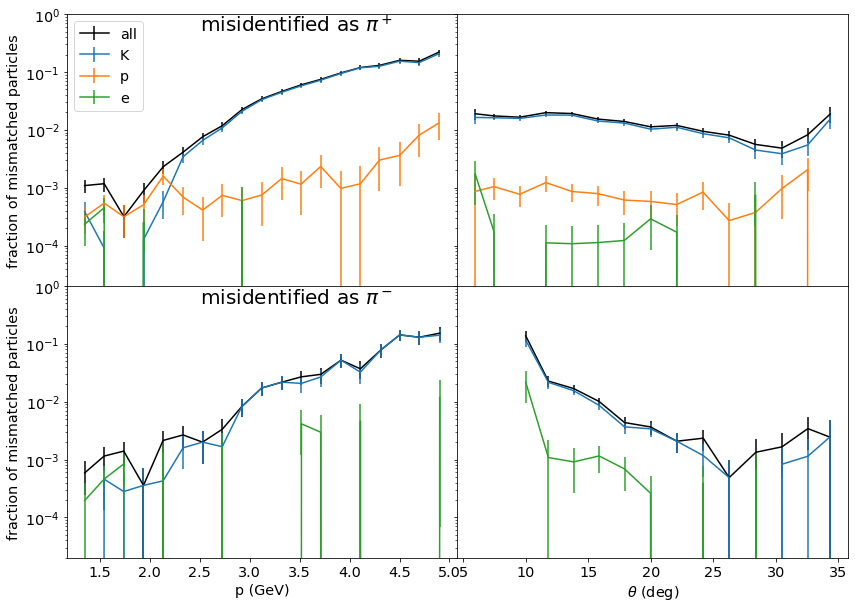

In [19]:
fig, axs = plt.subplots(2,2,figsize=(14,10),sharex='col',sharey='row')
fig.subplots_adjust(wspace=0, hspace=0)
for i,(df,name) in enumerate(zip([mc_hadrons.query("h_p > 0 and h_truth_p > 0 and h_pid==211"),
                      mc_hadrons.query("h_p > 0 and h_truth_p > 0 and h_pid==-211")],
                              "$\\pi^+$ $\\pi^-$".split())):
    for j,(xvar,xrange) in enumerate([("h_truth_p", (1.25,5)),("h_truth_th*180/3.14159", (0,40))]):
        pids = [321, 2212, 11]
        for selection,name2 in zip(["True"] +["abs(h_truth_pid) == %s" % pid for pid in pids],
                                 ["all", "K", "p","e"]):
            bins = binspace(df, xvar, *xrange, 20)
            x=[]
            y = []
            dy = []
            for bin in bins:
                num = len(bin.query("h_pid != h_truth_pid and "+ selection))
                denom = len(bin)
                if(denom != 0):
                    x.append(np.mean(bin.eval(xvar)))
                    y.append(num/denom)
                    dy.append(binomialError(num,denom))
            axs[i][j].errorbar(x,y,dy,label=name2,color='k' if name2=='all' else None)
            plt.sca(axs[i][j])
            plt.yscale("log")
axs[0][0].legend()
axs[0][0].set_ylabel("fraction of mismatched particles")
axs[1][0].set_ylabel("fraction of mismatched particles")
axs[0][0].set_ylim(2e-5,1)
axs[1][0].set_ylim(2e-5,1)
axs[0][0].text(2.5, 0.5,"misidentified as $\\pi^+$",size=20)
axs[1][0].text(2.5, 0.5,"misidentified as $\\pi^-$",size=20)
axs[1][0].set_xlabel("p (GeV)")
axs[1][1].set_xlabel("$\\theta$ (deg)")
fig.savefig("../images/pions_mispid.pdf")

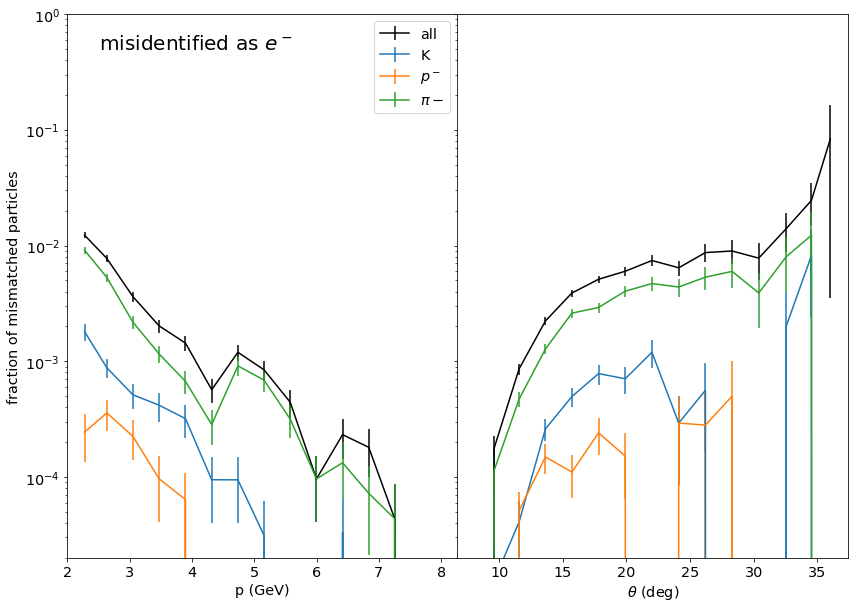

In [22]:
#same for electrons
fig, axs = plt.subplots(1,2,figsize=(14,10),sharex='col',sharey='row')
fig.subplots_adjust(wspace=0, hspace=0)
df = mc_electrons.query("e_p > 0 and e_truth_p > 0")
for j,(xvar,xrange) in enumerate([("e_truth_p", (2,10)),("e_truth_th*180/3.14159", (0,40))]):
    pids = [321, 2212,211]
    for selection,name in zip(["True"] +["abs(e_truth_pid) == %s" % pid for pid in pids],
                             ["all", "K","$p^-$","$\\pi-$"]):
        bins = binspace(df, xvar, *xrange, 20)
        x=[]
        y = []
        dy = []
        for bin in bins:
            num = len(bin.query("e_truth_pid != 11 and "+ selection))
            denom = len(bin)
            if(denom != 0):
                x.append(np.mean(bin.eval(xvar)))
                y.append(num/denom)
                dy.append(binomialError(num,denom))
        axs[j].errorbar(x,y,dy,label=name,color= 'k' if name =='all' else None)
        plt.sca(axs[j])
        plt.yscale("log")
axs[0].legend()
axs[0].set_ylabel("fraction of mismatched particles")
axs[0].set_ylim(2e-5,1)
axs[0].set_xlabel("p (GeV)")
axs[1].set_xlabel("$\\theta$ (deg)")
axs[0].text(2.5, 0.5,"misidentified as $e^-$",size=20)
fig.savefig("../images/electrons_mispid.pdf")

In [92]:
df = mc_electrons.query("e_p > 0 and e_truth_p > 0")
print(len(df.query("e_truth_pid != 11")),len(df.query("e_truth_pid != 11 and abs(e_truth_pid)==")))


2295       -211.0
5576       -211.0
9313       -211.0
11568      2212.0
12284      -211.0
            ...  
2166433    -211.0
2170467    -321.0
2172618    -321.0
2176790    2103.0
2177745    -211.0
Name: e_truth_pid, Length: 910, dtype: float64
